#RESEARCH QUESTION

Using a set of breast cancer data, create a model to predict breast cancer. Also, what traits are most indicative of whether or not an individual will be diagnosed?

In [0]:
#Import Libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn
from sklearn import linear_model
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import os
%matplotlib inline 
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", 
                        module="scipy", 
                        message="^internal gelsd")

#DATA PRE-PREPROCESSING

The first step is to load the data and gain a better understanding of the information each column contains. This data set was pulled from the UCI Machine Learning Repository. It contains a total of 30 measurements derived from fine needle aspirate (FNA) images of a breast mass taken from patients at three (3) separate times. All variables (with exception of ‘ID number’ and ‘Diagnosis’) were continuous floats rounded to the fourth decimal place. 

Link: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29


In [43]:
#Import Data for Challenge
from google.colab import files
uploaded = files.upload()

Saving breast_cancer.data to breast_cancer (1).data


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['breast_cancer.data']), header=0)
#These column names were present in a txt file that accompanied the dataset 
#(For more info please see txt file)
colnames =['id_number', 'diagnosis', 'M_radius','M_texture', 'M_perimeter', 
'M_area', 'M_smoothness', 'M_compactness', 'M_concavity', 'M_concave points', 
'M_symmetry','M_fractal dimension', 'SE_radius','SE_texture', 'SE_perimeter', 
'SE_area', 'SE_smoothness', 'SE_compactness', 'SE_concavity', 'SE_concave points', 
'SE_symmetry','SE_fractal dimension', 'Worst_radius','Worst_texture', 
'Worst_perimeter','Worst_area', 'Worst_smoothness', 'Worst_compactness', 
'Worst_concavity','Worst_concave points','Worst_symmetry',
'Worst_fractal dimension']
df.columns=colnames

In [45]:
# Take an initial look at the data provided 
df.head(20)

,id_number,diagnosis,M_radius,M_texture,M_perimeter,M_area,M_smoothness,M_compactness,M_concavity,M_concave points,M_symmetry,M_fractal dimension,SE_radius,SE_texture,SE_perimeter,SE_area,SE_smoothness,SE_compactness,SE_concavity,SE_concave points,SE_symmetry,SE_fractal dimension,Worst_radius,Worst_texture,Worst_perimeter,Worst_area,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave points,Worst_symmetry,Worst_fractal dimension
0,842517,M,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,0.057,0.543,0.734,3.398,74.080,0.005,0.013,0.019,0.013,0.014,0.004,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089
1,84300903,M,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.030,0.006,0.040,0.038,0.021,0.022,0.005,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088
2,84348301,M,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,0.097,0.496,1.156,3.445,27.230,0.009,0.075,0.057,0.019,0.060,0.009,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173
3,84358402,M,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.440,0.011,0.025,0.057,0.019,0.018,0.005,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077
4,843786,M,12.450,15.700,82.570,477.100,0.128,0.170,0.158,0.081,0.209,0.076,0.335,0.890,2.217,27.190,0.008,0.033,0.037,0.011,0.022,0.005,15.470,23.750,103.400,741.600,0.179,0.525,0.535,0.174,0.399,0.124
5,844359,M,18.250,19.980,119.600,1040.000,0.095,0.109,0.113,0.074,0.179,0.057,0.447,0.773,3.180,53.910,0.004,0.014,0.023,0.010,0.014,0.002,22.880,27.660,153.200,1606.000,0.144,0.258,0.378,0.193,0.306,0.084
6,84458202,M,13.710,20.830,90.200,577.900,0.119,0.165,0.094,0.060,0.220,0.075,0.584,1.377,3.856,50.960,0.009,0.030,0.025,0.014,0.015,0.005,17.060,28.140,110.600,897.000,0.165,0.368,0.268,0.156,0.320,0.115
7,844981,M,13.000,21.820,87.500,519.800,0.127,0.193,0.186,0.094,0.235,0.074,0.306,1.002,2.406,24.320,0.006,0.035,0.036,0.012,0.021,0.004,15.490,30.730,106.200,739.300,0.170,0.540,0.539,0.206,0.438,0.107
8,84501001,M,12.460,24.040,83.970,475.900,0.119,0.240,0.227,0.085,0.203,0.082,0.298,1.599,2.039,23.940,0.007,0.072,0.077,0.014,0.018,0.010,15.090,40.680,97.650,711.400,0.185,1.058,1.105,0.221,0.437,0.207
9,845636,M,16.020,23.240,102.700,797.800,0.082,0.067,0.033,0.033,0.153,0.057,0.380,1.187,2.466,40.510,0.004,0.009,0.011,0.008,0.015,0.003,19.190,33.880,123.800,1150.000,0.118,0.155,0.146,0.100,0.295,0.085


In [46]:
#Use .info method for data exploration
df.info()
#df.dtypes
print ('All the values provided in this dataset are floats with the exception' 
       ' of diagnosis. That should be categorical. In this case I will make it' 
       'binary')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 32 columns):
id_number                  568 non-null int64
diagnosis                  568 non-null object
M_radius                   568 non-null float64
M_texture                  568 non-null float64
M_perimeter                568 non-null float64
M_area                     568 non-null float64
M_smoothness               568 non-null float64
M_compactness              568 non-null float64
M_concavity                568 non-null float64
M_concave points           568 non-null float64
M_symmetry                 568 non-null float64
M_fractal dimension        568 non-null float64
SE_radius                  568 non-null float64
SE_texture                 568 non-null float64
SE_perimeter               568 non-null float64
SE_area                    568 non-null float64
SE_smoothness              568 non-null float64
SE_compactness             568 non-null float64
SE_concavity               568 non

In [0]:
#Converting the diagnosis column (dependent/target variable) to a categorical 
#column 
df["diagnosis"] = df['diagnosis'].astype('category')

In [48]:
# Count of missing values
print (df.isnull().sum())
print ("Looks like there is nothing missing in this dataframe. This is" 
          "consistent with information provided in txt file accompanying the"
          "dataset")

id_number                  0
diagnosis                  0
M_radius                   0
M_texture                  0
M_perimeter                0
M_area                     0
M_smoothness               0
M_compactness              0
M_concavity                0
M_concave points           0
M_symmetry                 0
M_fractal dimension        0
SE_radius                  0
SE_texture                 0
SE_perimeter               0
SE_area                    0
SE_smoothness              0
SE_compactness             0
SE_concavity               0
SE_concave points          0
SE_symmetry                0
SE_fractal dimension       0
Worst_radius               0
Worst_texture              0
Worst_perimeter            0
Worst_area                 0
Worst_smoothness           0
Worst_compactness          0
Worst_concavity            0
Worst_concave points       0
Worst_symmetry             0
Worst_fractal dimension    0
dtype: int64
Looks like there is nothing missing in this dataframe. This

Let's dive deeper to review datapoints in each column. It apears there are a few outliers in the "Area" parameter. 

In [49]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id_number,568.000,30423820.040,125124628.307,8670.000,869222.500,906157.000,8825022.250,911320502.000
M_radius,568.000,14.120,3.523,6.981,11.697,13.355,15.780,28.110
M_texture,568.000,19.305,4.289,9.710,16.178,18.855,21.803,39.280
M_perimeter,568.000,91.915,24.286,43.790,75.135,86.210,103.875,188.500
M_area,568.000,654.280,351.924,143.500,420.175,548.750,782.625,2501.000
M_smoothness,568.000,0.096,0.014,0.053,0.086,0.096,0.105,0.163
M_compactness,568.000,0.104,0.052,0.019,0.065,0.093,0.130,0.345
M_concavity,568.000,0.088,0.079,0.000,0.030,0.061,0.130,0.427
M_concave points,568.000,0.049,0.039,0.000,0.020,0.033,0.074,0.201
M_symmetry,568.000,0.181,0.027,0.106,0.162,0.179,0.196,0.304


In [50]:
#Take a look at entries with a M_Area of >1000
df[df['M_area']>1000]
#We can possibly deal with these outlier cases separately but there are not 
#enough. 

,id_number,diagnosis,M_radius,M_texture,M_perimeter,M_area,M_smoothness,M_compactness,M_concavity,M_concave points,M_symmetry,M_fractal dimension,SE_radius,SE_texture,SE_perimeter,SE_area,SE_smoothness,SE_compactness,SE_concavity,SE_concave points,SE_symmetry,SE_fractal dimension,Worst_radius,Worst_texture,Worst_perimeter,Worst_area,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave points,Worst_symmetry,Worst_fractal dimension
0,842517,M,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,0.057,0.543,0.734,3.398,74.080,0.005,0.013,0.019,0.013,0.014,0.004,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089
1,84300903,M,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.030,0.006,0.040,0.038,0.021,0.022,0.005,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088
3,84358402,M,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.440,0.011,0.025,0.057,0.019,0.018,0.005,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077
5,844359,M,18.250,19.980,119.600,1040.000,0.095,0.109,0.113,0.074,0.179,0.057,0.447,0.773,3.180,53.910,0.004,0.014,0.023,0.010,0.014,0.002,22.880,27.660,153.200,1606.000,0.144,0.258,0.378,0.193,0.306,0.084
11,846226,M,19.170,24.800,132.400,1123.000,0.097,0.246,0.206,0.112,0.240,0.078,0.956,3.568,11.070,116.200,0.003,0.083,0.089,0.041,0.045,0.013,20.960,29.940,151.700,1332.000,0.104,0.390,0.364,0.177,0.318,0.102
17,849014,M,19.810,22.150,130.000,1260.000,0.098,0.103,0.148,0.095,0.158,0.054,0.758,1.017,5.865,112.400,0.006,0.019,0.034,0.015,0.014,0.002,27.320,30.880,186.800,2398.000,0.151,0.315,0.537,0.239,0.277,0.076
22,851509,M,21.160,23.040,137.200,1404.000,0.094,0.102,0.110,0.086,0.177,0.053,0.692,1.127,4.303,93.990,0.005,0.013,0.017,0.010,0.011,0.002,29.170,35.590,188.000,2615.000,0.140,0.260,0.316,0.201,0.282,0.075
26,852781,M,18.610,20.250,122.100,1094.000,0.094,0.107,0.149,0.077,0.170,0.057,0.853,1.849,5.632,93.540,0.011,0.027,0.051,0.019,0.023,0.004,21.310,27.260,139.900,1403.000,0.134,0.212,0.345,0.149,0.234,0.074
29,853401,M,18.630,25.110,124.800,1088.000,0.106,0.189,0.232,0.124,0.218,0.062,0.831,1.466,5.574,105.000,0.006,0.034,0.052,0.012,0.020,0.005,23.150,34.010,160.500,1670.000,0.149,0.426,0.613,0.185,0.344,0.098
32,854002,M,19.270,26.470,127.900,1162.000,0.094,0.172,0.166,0.076,0.185,0.063,0.556,0.606,3.528,68.170,0.005,0.033,0.035,0.010,0.015,0.004,24.150,30.900,161.400,1813.000,0.151,0.659,0.609,0.178,0.367,0.112


In [51]:
print ('I will run the models with these outliers and then drop them to see if '
       'that improves accuracy.')

I will run the models with these outliers and then drop them to see if that improves accuracy.


#DEPENDENT VARIABLE EXPLORATION

The dependent (or target) variable we are trying to predict in this analysis is 'Diagnosis' - is the tumor benign or malignant. In other words does the patient have cancer?

Text(0.5, 1.0, 'Number of Benign and Malignant Diagnoses in Dataset')

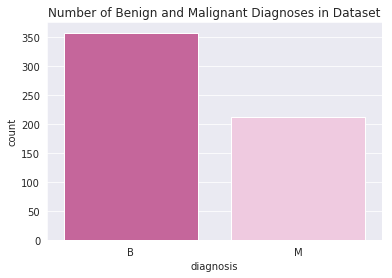

In [52]:
sequential_colors = sns.color_palette("PiYG", 5)
sns.set_palette(sequential_colors)
sns.set_style('darkgrid')
ax = sns.countplot(df['diagnosis'],label="Count") 
ax.set_title('Number of Benign and Malignant Diagnoses in Dataset')


In [53]:
df['diagnosis'].value_counts()
#There are 146 more Benign tumors in the dataset than Malignant ones - leading 
#to class imbalance. If needed, we can oversample from the Malignant population 
#so that the model can better predict the malignant tumors. 

B    357
M    211
Name: diagnosis, dtype: int64

REVIEW OF SMOTE 

SMOTE (Synthetic Minority Over-sampling Technique). It’s the process of creating a new minority classes using K-nearest neighbors from the datasets. SMOTE is imported using the code "from imblearn.over_sampling import SMOTE"

#FEATURE DATA EXPLORATION

Take a closer look at the features to see how they relate to the target variable (Diagnosis) and each other. 

In [0]:
#Define X and Y 
y = df.diagnosis                          
list = ['id_number','diagnosis']
x = df.drop(list,axis = 1 ) #x is our set of features 

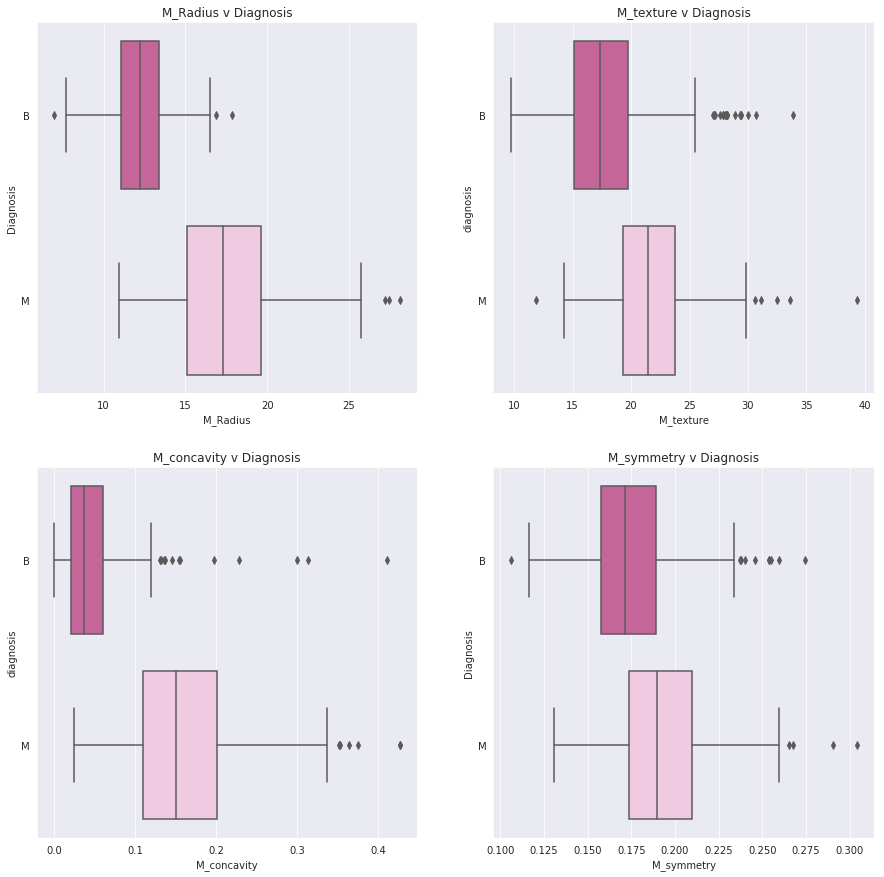

In [55]:
# Suplots of M_features v diagnosis
# I chose to graph these features because I believe the others may be redundant
# based on basic geometric principles (e.g., radius and area). I will check if 
#they are using a corr matrix. 
sns.set_style('darkgrid')
f, axes = plt.subplots(2,2, figsize = (15,15))

# Plot [0,0]
sns.boxplot(data = df, x = 'M_radius', y = 'diagnosis', ax = axes[0,0])
axes[0,0].set_xlabel('M_Radius')
axes[0,0].set_ylabel('Diagnosis')
axes[0,0].set_title('M_Radius v Diagnosis')

# Plot [0,1]
sns.boxplot(x = 'M_texture', y = 'diagnosis', data = df, ax = axes[0,1])
axes[0,1].set_xlabel('M_texture')
#axes[0,1].set_ylabel('Diagnosis')
axes[0,1].set_title('M_texture v Diagnosis')

# Plot [1,0]
sns.boxplot(x = 'M_concavity', y = 'diagnosis', data = df, ax = axes[1,0])
axes[1,0].set_xlabel('M_concavity')
#axes[1,0].set_ylabel('Price')
axes[1,0].set_title('M_concavity v Diagnosis')

# Plot [1,1]
sns.boxplot(x = 'M_symmetry', y = 'diagnosis', data = df, ax = axes[1,1])
axes[1,1].set_xlabel('M_symmetry')
axes[1,1].set_ylabel('Diagnosis')
axes[1,1].set_title('M_symmetry v Diagnosis')

plt.show()


The box plot of these mean features shows thre are a few extreme outliers. This is consistent to what we saw above. 

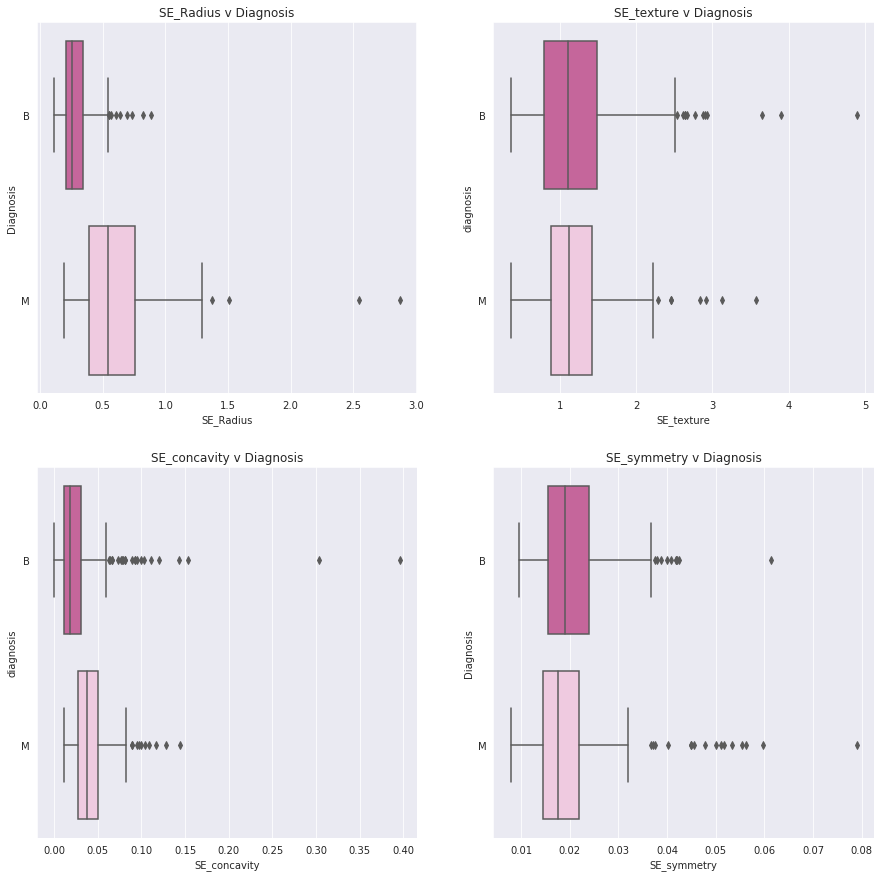

In [56]:
# Suplots of SE_features v diagnosis
sns.set_style('darkgrid')
f, axes = plt.subplots(2,2, figsize = (15,15))

# Plot [0,0]
sns.boxplot(data = df, x = 'SE_radius', y = 'diagnosis', ax = axes[0,0])
axes[0,0].set_xlabel('SE_Radius')
axes[0,0].set_ylabel('Diagnosis')
axes[0,0].set_title('SE_Radius v Diagnosis')

# Plot [0,1]
sns.boxplot(x = 'SE_texture', y = 'diagnosis', data = df, ax = axes[0,1])
axes[0,1].set_xlabel('SE_texture')
#axes[0,1].set_ylabel('Diagnosis')
axes[0,1].set_title('SE_texture v Diagnosis')

# Plot [1,0]
sns.boxplot(x = 'SE_concavity', y = 'diagnosis', data = df, ax = axes[1,0])
axes[1,0].set_xlabel('SE_concavity')
#axes[1,0].set_ylabel('Price')
axes[1,0].set_title('SE_concavity v Diagnosis')

# Plot [1,1]
sns.boxplot(x = 'SE_symmetry', y = 'diagnosis', data = df, ax = axes[1,1])
axes[1,1].set_xlabel('SE_symmetry')
axes[1,1].set_ylabel('Diagnosis')
axes[1,1].set_title('SE_symmetry v Diagnosis')

plt.show()
#Opportunities to compare - potential to drop SE 

The above graphs show that the standard error for benign and malignant are rather similar indicating that it is probably not the best set of feature to use to predict M vs B. 

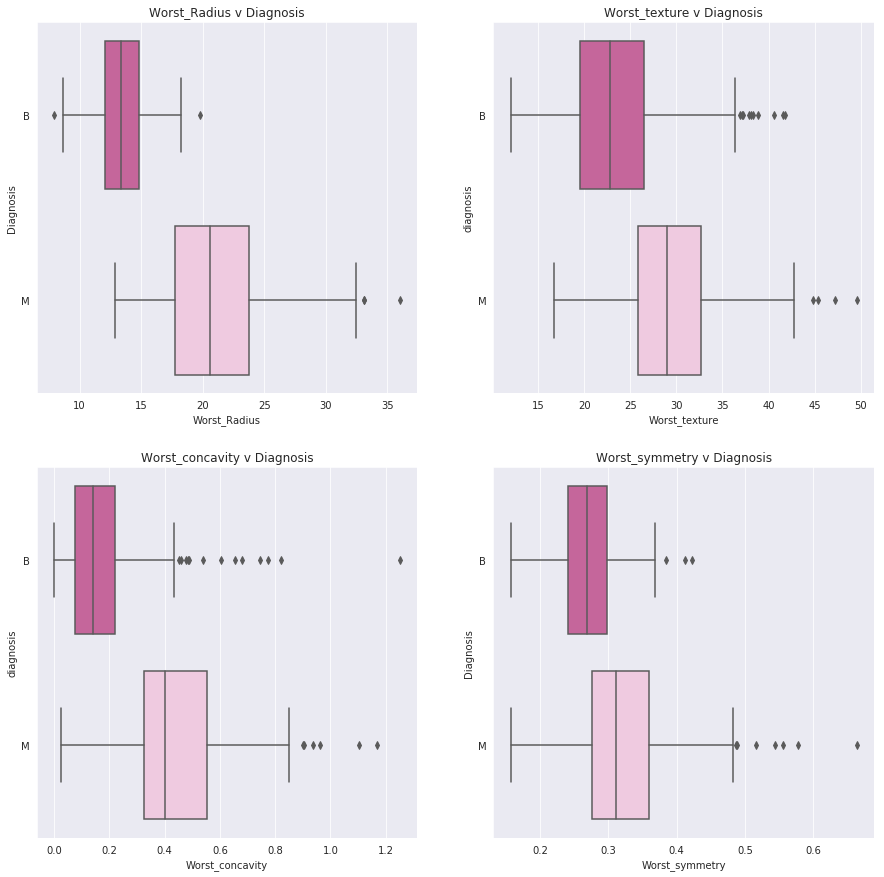

In [57]:
# Suplots of Worst_features v diagnosis
sns.set_style('darkgrid')
f, axes = plt.subplots(2,2, figsize = (15,15))

# Plot [0,0]
sns.boxplot(data = df, x = 'Worst_radius', y = 'diagnosis', ax = axes[0,0])
axes[0,0].set_xlabel('Worst_Radius')
axes[0,0].set_ylabel('Diagnosis')
axes[0,0].set_title('Worst_Radius v Diagnosis')

# Plot [0,1]
sns.boxplot(x = 'Worst_texture', y = 'diagnosis', data = df, ax = axes[0,1])
axes[0,1].set_xlabel('Worst_texture')
#axes[0,1].set_ylabel('Diagnosis')
axes[0,1].set_title('Worst_texture v Diagnosis')

# Plot [1,0]
sns.boxplot(x = 'Worst_concavity', y = 'diagnosis', data = df, ax = axes[1,0])
axes[1,0].set_xlabel('Worst_concavity')
#axes[1,0].set_ylabel('Price')
axes[1,0].set_title('Worst_concavity v Diagnosis')

# Plot [1,1]
sns.boxplot(x = 'Worst_symmetry', y = 'diagnosis', data = df, ax = axes[1,1])
axes[1,1].set_xlabel('Worst_symmetry')
axes[1,1].set_ylabel('Diagnosis')
axes[1,1].set_title('Worst_symmetry v Diagnosis')

plt.show()


#CORRELATION 

My next step is to see how these variables are correlated with each other. 

Text(0.5, 1.0, 'Variable Correlation without Y')

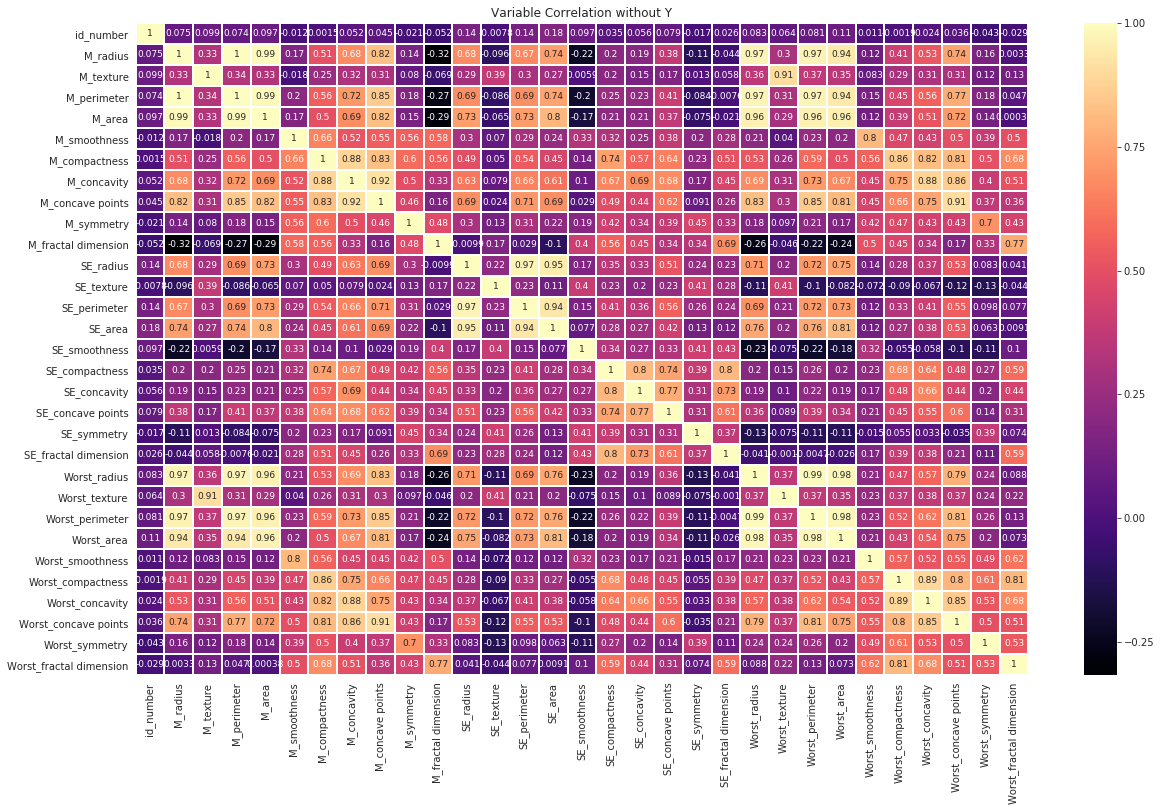

In [58]:
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(),cmap = 'magma',linewidth = 1,annot= True, 
            annot_kws={"size": 9})
plt.title('Variable Correlation without Y')

In [59]:
#Here I created (with help!) an evaluation function that shows any feature 
#with a correlation > .7
#type(df.corr()) #corr matrix is a data frame 
def highcorr (n):
  #print (n.index.values)
  row_index = (n.index.values)
  for row in range (len(n)): #corr is always a square therefore we use len of n
    for col in range (row):
      if n.iloc[row, col] > .7:
        print (row_index[row], row_index[col], n.iloc[row,col])
 
highcorr(df.corr())

M_perimeter M_radius 0.997876387978384
M_area M_radius 0.9873441660377353
M_area M_perimeter 0.9865481730438745
M_concavity M_perimeter 0.7156622431705518
M_concavity M_compactness 0.8816187088384307
M_concave points M_radius 0.8231652824395475
M_concave points M_perimeter 0.8513375336061465
M_concave points M_area 0.8242459350659573
M_concave points M_compactness 0.8290502417166027
M_concave points M_concavity 0.9204621339636965
SE_radius M_area 0.7328794151149762
SE_perimeter M_area 0.7274931056669701
SE_perimeter M_concave points 0.7070059164053665
SE_perimeter SE_radius 0.9725550326176915
SE_area M_radius 0.7358541290704966
SE_area M_perimeter 0.7445397153642671
SE_area M_area 0.8008287064020758
SE_area SE_radius 0.9512990869301273
SE_area SE_perimeter 0.936973080858883
SE_compactness M_compactness 0.7392777423223634
SE_concavity SE_compactness 0.8011829332983565
SE_concave points SE_compactness 0.7439727707682428
SE_concave points SE_concavity 0.7716143316805709
SE_fractal dimensi

As shown above, there is a significant amount of multicolinearity . 

Correlation Observations 

- As expected M_area, M_perimeter, and M_radius  are highly correlated 
- Worst_area, Worst_perimiter, and Worst_radius are also highly correlated with M of the same type
- SE_area, SE_perimeter, and SE_radius are also highly correlated with M and SE of the same type 
- M_compactness, M_concavity and M_concave points are also highly correlated 

Correlation Outputs 

- I will drop the  extremely correlated area, perimeter, and radius variables , as well as, the M-concavity and M_concave point variables. 
-Due to the multicolinarity , as a next step I may want to use PCA

In [60]:
#Next, I convert diagnosis to a binary column
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
print (df['diagnosis'])

0      1
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     0
19     0
20     0
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
      ..
538    0
539    0
540    0
541    0
542    0
543    0
544    0
545    0
546    0
547    0
548    0
549    0
550    0
551    0
552    0
553    0
554    0
555    0
556    0
557    0
558    0
559    0
560    0
561    1
562    1
563    1
564    1
565    1
566    1
567    0
Name: diagnosis, Length: 568, dtype: int64


In [0]:
#Here I am dropping the highly correlated features mentioned above. 
df2  = df.drop(columns =['M_perimeter', 'M_radius', 'M_concavity', 'M_concave points', 
                         'Worst_area', 'Worst_perimeter', 
                         'Worst_radius', 'SE_area', 'SE_perimeter', 
                         'SE_radius'])

In [62]:
#Check to make sure columns dropped appropriately 
df2.head()

,id_number,diagnosis,M_texture,M_area,M_smoothness,M_compactness,M_symmetry,M_fractal dimension,SE_texture,SE_smoothness,SE_compactness,SE_concavity,SE_concave points,SE_symmetry,SE_fractal dimension,Worst_texture,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave points,Worst_symmetry,Worst_fractal dimension
0,842517,1,17.770,1326.000,0.085,0.079,0.181,0.057,0.734,0.005,0.013,0.019,0.013,0.014,0.004,23.410,0.124,0.187,0.242,0.186,0.275,0.089
1,84300903,1,21.250,1203.000,0.110,0.160,0.207,0.060,0.787,0.006,0.040,0.038,0.021,0.022,0.005,25.530,0.144,0.424,0.450,0.243,0.361,0.088
2,84348301,1,20.380,386.100,0.142,0.284,0.260,0.097,1.156,0.009,0.075,0.057,0.019,0.060,0.009,26.500,0.210,0.866,0.687,0.258,0.664,0.173
3,84358402,1,14.340,1297.000,0.100,0.133,0.181,0.059,0.781,0.011,0.025,0.057,0.019,0.018,0.005,16.670,0.137,0.205,0.400,0.163,0.236,0.077
4,843786,1,15.700,477.100,0.128,0.170,0.209,0.076,0.890,0.008,0.033,0.037,0.011,0.022,0.005,23.750,0.179,0.525,0.535,0.174,0.399,0.124


Text(0.5, 1.0, 'Variable Correlation (10 less features)')

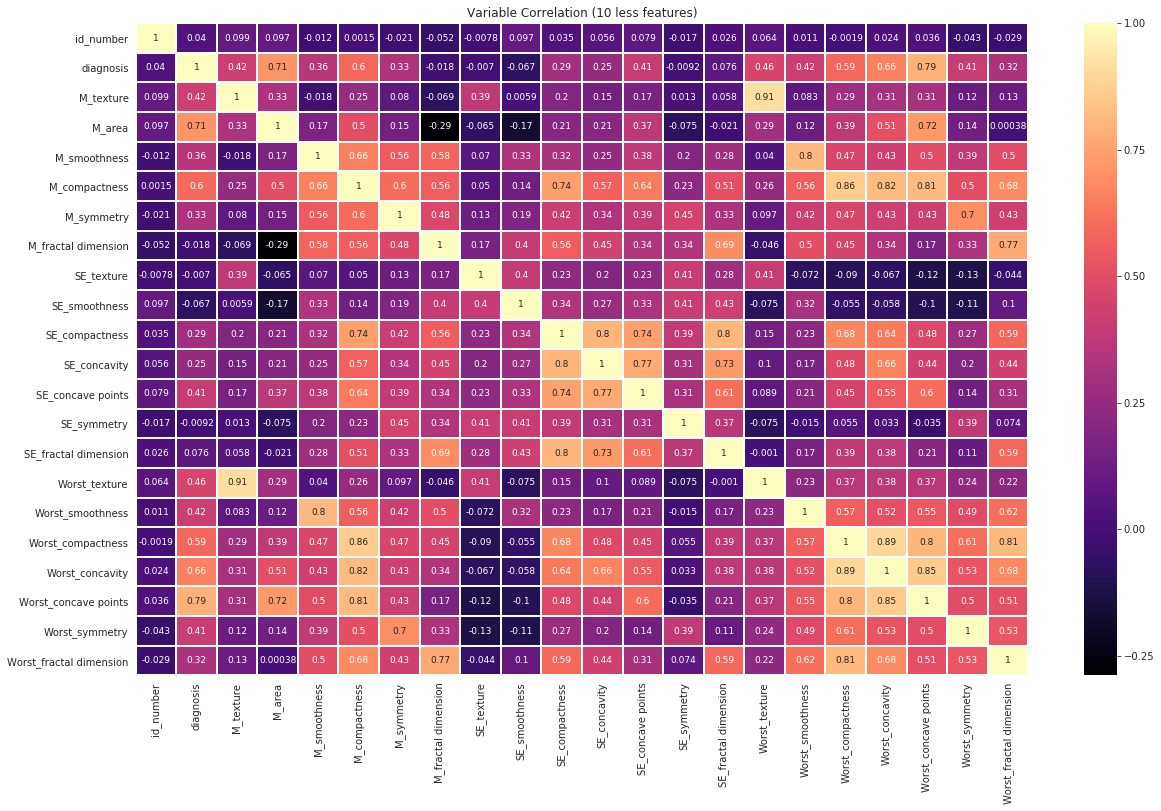

In [63]:
plt.figure(figsize=(20,12))
sns.heatmap(df2.corr(),cmap = 'magma',linewidth = 1,annot= True, 
            annot_kws={"size": 9})
plt.title('Variable Correlation (10 less features)')

#RUN OUR FIRST MODELS

It is now time to run our first models. As stated above I will try improving the models with PCA if deemed necessary. 

In [0]:
#With a new df2 ;et's redefine X&Y first 
#(Keeping in most of the features this go around)
#Define X and Y 
y2 = df2.diagnosis                          
list = ['id_number','diagnosis']
x2 = df2.drop(list,axis = 1 ) #x is our set of features 

In [0]:
# Train, test, split
from sklearn.model_selection import train_test_split
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2, test_size = .30, 
                                                        random_state= 0)

In [66]:
#LINEAR REGRESSION #1 - TRAINING SET  

# Import model
from sklearn.linear_model import LinearRegression

# Create linear regression object
regr = LinearRegression()

# Fit model to training data
regr.fit(x2_train, y2_train) #compare with test and just rerun

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(x2, y2)) 


Coefficients: 
 [-5.33282810e-05  3.95996710e-04  1.61690328e+00  2.71510776e-01
 -5.05233246e-02 -1.31290543e+01  1.31736307e-02  1.53584067e+01
 -3.92340539e+00 -3.34111339e+00  4.56457221e+00  1.84328777e+00
  2.60594006e+01  1.01314051e-02  5.12055966e-01 -1.83095152e-01
  6.15840917e-01  2.64839256e+00  6.49544181e-01  2.89660686e+00]

Intercept: 
 -0.5311106166513974

R-squared:
0.7267851336392251


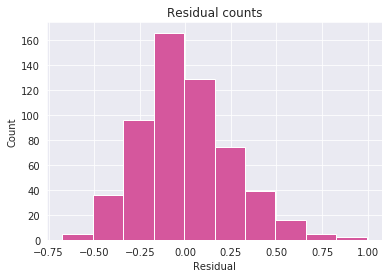

In [67]:
# Extract predicted values.
predicted = regr.predict(x2).ravel()
actual = df2['diagnosis']

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# 72.6% of the variation in the data can be accounted for with this model


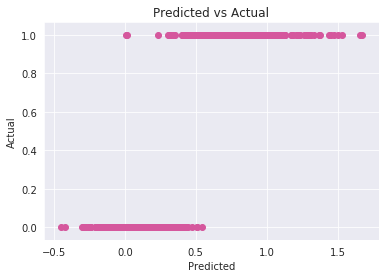

In [68]:
#Create a scatter plot of predicted value vs actual 
plt.scatter(predicted, actual)
plt.title('Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [69]:
#Now we can take a closer look at the coefficients to see how well our model 
#worked. 
coef_df = pd.DataFrame(data = regr.coef_, index = x2.columns, columns = 
                       ['Coefficients'])
coef_df

,Coefficients
M_texture,-0.000
M_area,0.000
M_smoothness,1.617
M_compactness,0.272
M_symmetry,-0.051
M_fractal dimension,-13.129
SE_texture,0.013
SE_smoothness,15.358
SE_compactness,-3.923
SE_concavity,-3.341


In [74]:
#LINEAR REGRESSION #1 - TEST 

# Import model
from sklearn.linear_model import LinearRegression

# Create linear regression object
regr = LinearRegression()

# Fit model to training data
regr.fit(x2_test, y2_test)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(x2, y2)) 


Coefficients: 
 [ 3.23000004e-02  4.58830659e-04  1.97989256e+00 -7.86496292e-01
 -9.50363014e-01 -1.99795368e+01  8.43574745e-02  3.01966058e+01
  5.67082208e+00 -3.98601969e+00  1.88149235e+01 -3.05147658e+00
 -5.14558479e+01 -1.14992417e-02 -2.58792849e+00 -1.85797427e+00
  8.59644496e-01  2.43472897e+00  2.53015519e+00  1.53487438e+01]

Intercept: 
 -0.9565031617506425

R-squared:
0.6864551287423677


In [0]:
#I use cross validation here to check for overfitting 
from sklearn.model_selection import cross_val_score
from sklearn import svm
scores_lin = cross_val_score(crossval, x2, y2, cv=5)
scores_lin                                              

array([0.91304348, 0.92105263, 0.97345133, 0.9380531 , 0.98230088])

In [0]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_lin.mean(), scores_lin.std() * 2))

Accuracy: 0.95 (+/- 0.06)


The cross validation check shows that there is some overfitting occuring when my linear regression model is run. 

In [0]:
#LOGISTIC REGRESSION - TRAIN 
#Because we have a binary outcome variable I would next like to try logistic 
#regression 

# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9)

# Fit the model.
fit = lr.fit(x2_train, y2_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(x2)

print('\n Accuracy by Diagnosis')
print(pd.crosstab(pred_y_sklearn, y2))

print('\n Percentage accuracy')
print(lr.score(x2, y2))

#Investigate and add Type 1 and Type 2 errors, precision(row) and recall, review 
#bias and variance. Reciever Operator Charateristic Curve - Kevin Markum 

Coefficients
[[-2.52347017e-01  1.46565410e-02  6.96980072e+00  8.00469037e+00
   4.11135499e+00 -7.72318725e-02 -1.32346666e+00  1.17245183e+00
  -2.57860397e+00 -3.06612893e+00  1.15616968e+00  7.96030992e-01
  -1.10305376e-01  4.76575269e-01  1.16235022e+01 -3.18581156e-02
   4.62017994e+00  1.75744783e+01  7.98753943e+00  9.66641214e-01]]
[-25.93095737]

 Accuracy by Diagnosis
diagnosis    0    1
row_0              
0          354   14
1            3  197

 Percentage accuracy
0.9700704225352113


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


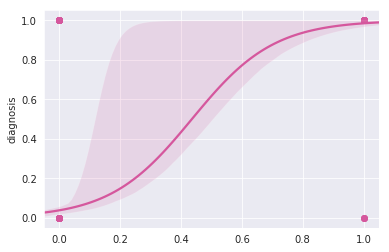

In [0]:
# Extract predicted values.
predicted_log = lr.predict(x2).ravel()
actual_log = df2['diagnosis']
# Calculate the error, also called the residual.
residual_log = actual_log - predicted_log

sns.regplot(x=predicted_log, y=actual_log, data=df2, logistic=True)
#The shaded error represents the confidence interval. 

In [0]:
# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report  
results = confusion_matrix(actual_log, predicted_log) 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :'),accuracy_score(actual_log, predicted_log) 
print ('Report : ')
print (classification_report(actual_log, predicted_log)) 

Confusion Matrix :
[[354   3]
 [ 14 197]]
Accuracy Score :
Report : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       357
           1       0.98      0.93      0.96       211

    accuracy                           0.97       568
   macro avg       0.97      0.96      0.97       568
weighted avg       0.97      0.97      0.97       568



In [0]:
#LOGISTIC REGRESSION - TEST 
#Because we have a binary outcome variable I would next like to try logistic regression 

# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9)

# Fit the model.
fit = lr.fit(x2_test, y2_test)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(x2)

print('\n Accuracy by Diagnosis')
print(pd.crosstab(pred_y_sklearn, y2))

print('\n Percentage accuracy')
print(lr.score(x2, y2))

Coefficients
[[ 8.56267940e-01  2.61728880e-02  2.01423260e+01 -2.03076850e+01
  -1.91684087e+01 -2.10455409e+00  4.26853488e+00  3.57851756e+00
  -1.42767939e+01 -1.31418937e+01  5.07113837e+00 -6.08801221e+00
  -1.92268867e+00 -2.07095295e-01  5.42941683e+01 -2.88106429e+01
   3.28928715e+01  3.23971527e+01  3.39677493e+01 -4.29948643e-01]]
[-51.62294834]

 Accuracy by Diagnosis
diagnosis    0    1
row_0              
0          337   12
1           20  199

 Percentage accuracy
0.9436619718309859


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


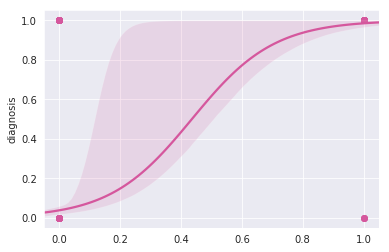

In [0]:
# Extract predicted values.
predicted_log2 = lr.predict(x2).ravel()
actual_log2 = df2['diagnosis']
# Calculate the error, also called the residual.
residual_log2 = actual_log2 - predicted_log2


sns.regplot(x=predicted_log2, y=actual_log2, data=df2, logistic=True)


In [0]:
#RANDOM FORREST - TRAIN 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()  #Use gridsearch for hyperparameter
#ASK FOR HELP HEREE

#Train the model using the training sets 
rfc.fit(x2_train,y2_train)
y_pred2=rfc.predict(x2)
#cross_val_score(rfc, x2_train, y2_train, cv=5)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Prediction Accuracy:",metrics.accuracy_score(y2, y_pred2))
# Add confusion matrix for Random Forest Model

Prediction Accuracy: 0.971830985915493


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
#RANDOM FOREST - TEST 
#Train the model using the test sets 
rfc.fit(x2_test,y2_test)
y_pred3=rfc.predict(x2)
#cross_val_score(rfc, x2_train, y2_train, cv=5)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Prediction Accuracy:",metrics.accuracy_score(y2, y_pred3))

Prediction Accuracy: 0.954225352112676


In [0]:
 #RANDOM FORREST WITH GRADIENT BOOSTING - TRAIN
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(x2_train, y2_train)

predict_train = clf.predict(x2_train)
predict_test = clf.predict(x2_test)

print('\n Percentage accuracy')
print(clf.score(x2, y2))

# Accuracy tables.
table_train = pd.crosstab(y2_train, predict_train, margins=True)
table_test = pd.crosstab(y2_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))



 Percentage accuracy
0.9876760563380281
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.005847953216374269
Percent Type II errors: 0.03508771929824561


In [0]:
#RANDOM FORREST WITH GRADIENT BOOSTING - Test 

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(x2_test, y2_test)


print('\n Percentage accuracy')
print(clf.score(x2, y2))


 Percentage accuracy
0.9647887323943662


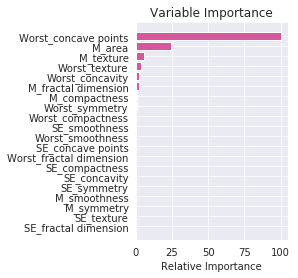

In [0]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x2.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
#drop the features from the feature and rerun the models on the remaining features 

#RUN OUR BEST PERFORMING MODEL AGAIN

For this exercise I will use Random Forrect with Gradient Boosting

In [0]:
#Here I create a new dataframe that drops all the outliers and the standard 
#error
df3 = df2.drop(columns = ['SE_texture', 'SE_smoothness', 'SE_compactness', 
                          'SE_concavity', 'SE_concave points', 'SE_symmetry',
                          'SE_fractal dimension'])
df3 = df3[df3.M_area < 1000]

In [0]:
#Redefine X&Y using the new dataframe 
y3 = df3.diagnosis                          
list = ['id_number','diagnosis']
x3 = df3.drop(list,axis = 1 ) #x is our set of features 

In [0]:
# Train, test, split
from sklearn.model_selection import train_test_split
x3_train, x3_test, y3_train, y3_test = train_test_split(x3,y3, test_size = .30, 
                                                        random_state= 0)

In [0]:
#RANDOM FORREST WITH GRADIENT BOOSTING - TRAIN
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params)
clf2.fit(x3_train, y3_train)

predict_train2 = clf2.predict(x3_train)
predict_test2 = clf2.predict(x3_test)

print('\n Percentage accuracy')
print(clf2.score(x3, y3))

# Accuracy tables.
table_train2 = pd.crosstab(y3_train, predict_train2, margins=True)
table_test2 = pd.crosstab(y3_test, predict_test2, margins=True)

train_tI_errors2 = table_train2.loc[0.0,1.0] / table_train2.loc['All','All']
train_tII_errors2 = table_train2.loc[1.0,0.0] / table_train2.loc['All','All']

test_tI_errors2 = table_test2.loc[0.0,1.0]/table_test2.loc['All','All']
test_tII_errors2 = table_test2.loc[1.0,0.0]/table_test2.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


 Percentage accuracy
0.9916142557651991
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.005847953216374269
Percent Type II errors: 0.03508771929824561


#CONCLUSION 

Measurements derived from fine needle aspirate (FNA) images of a breast mass can be used to predict whether or not a mass is malignant or benign with great accuracy. In addition, dropping the outliers and Standard Error features greatly improved my best performing model Random Forrest with Gradient Boost. An outstanding question I have with this dataset is whether or not it included any False Positives and/or False Negatives (i.e., a breast mass was labeled M but then later was discovered to benign and vice versa). 





# FURTHER RESEARCH 

- Use statsmodels to get the P-values for each coefficient. The P-values of a coefficents help you understand the probability that the coefficient is in error.
-  Review the Ginny Index to further  evaluate my random forrest models. In addition, research border irregularity and review decision boundaries. I may also want to review the primary root. 
- Try using PCA (but dataset is quite small)